# Use `while` loop


## Introduction

In this tutorial, you'll learn how to implement a `while` loop in WorkGraph, allowing you to execute a set of tasks repeatedly as long as a specified condition remains true. WorkGraph supports two methods for implementing a `while` loop:

1. **While instruction**
2. **While WorkGraph**

## Using the While instruction

WorkGraph provides a `while_` instruction that allows you to create a `while` loop in a WorkGraph. Here's a simple example to add a `while_` instruction to a WorkGraph:

```python
while_(task1.output.result, max_iterations=100)(
    wg.add_task(task2, name="task2", a=1, b=2),
)
```

### Example

Suppose we want to calculate the following workflow, the tasks for each step are shown:

In [1]:
from aiida_workgraph import WorkGraph, task
from aiida import load_profile

load_profile()

@task.calcfunction()
def compare(x, y):
    return x < y

@task.calcfunction()
def add(x, y):
    return x + y

@task.calcfunction()
def multiply(x, y):
    return x*y

#-------------------------------------------------------------------
# start while block
n = add(1, 1)            # task add1
# start while loop
while compare(n, 50):    # task compare
    n = add(n, 1)        # task add2
    n = multiply(n, 2)   # task multiply1
# end while block
z = add(n, 1)            # task add3
#-------------------------------------------------------------------

print("Result: ", z)

Result:  uuid: 5b9a6780-ac24-488b-b696-92dff8d8a4e8 (pk: 33882) value: 63


### Create the workflow
Now, let'use create the workflow using the `While` task.

In [2]:
from aiida_workgraph import task, WorkGraph, while_

wg = WorkGraph("while_task")
# set a context variable before running.
wg.context = {"should_run": True}
add1 = wg.add_task(add, name="add1", x=1, y=1)
add1.set_context({"n": "result"})
#---------------------------------------------------------------------
# Create the while zone
compare1 = wg.add_task(compare, name="compare1", x="{{n}}", y=50)
# Create the tasks in the while zone.
while_(compare1.outputs.result, max_iterations=100)(
    wg.add_task(add, name="add2", x="{{n}}", y=1),
    wg.tasks.add2.waiting_on.add("add1"),
    wg.add_task(multiply, name="multiply1",
                        x=wg.tasks.add2.outputs.result,
                        y=2),
    wg.tasks.multiply1.set_context({"n": "result"})
)
#---------------------------------------------------------------------
add3 = wg.add_task(add, name="add3", x=1, y=1)
wg.add_link(wg.tasks.multiply1.outputs.result, add3.inputs["x"])
wg.to_html()
# comment out the following line to visualize the graph in the notebook
wg

NodeGraphWidget(settings={'minimap': True}, style={'width': '90%', 'height': '600px'}, value={'name': 'while_t…

### GUI Representation

In the graphical user interface, the `while_` instruction is depicted as a **While Zone**, containing all its child tasks. This zone simplifies the visualization of the loop structure:

- **Linking Tasks**: Unlike regular tasks, the `While Zone` lacks data input and output sockets. Tasks outside the zone can directly link to those inside, facilitating a seamless workflow integration.


### Submit the WorkGraph and check the results


In [3]:
wg.submit(wait=True)
print("State of WorkGraph:   {}".format(wg.state))
print('Result of add1   :   {}'.format(add3.outputs["result"].value))

WorkGraph process created, PK: 33888
Process 33888 finished with state: FINISHED
State of WorkGraph:   FINISHED
Result of add1   :   uuid: 2fc7c906-8c02-477c-a947-2cb8e28360fb (pk: 33934) value: 63


Generate node graph from the AiiDA process,and we can see that when `compare1` node outputs `False`, the workgraph stops.

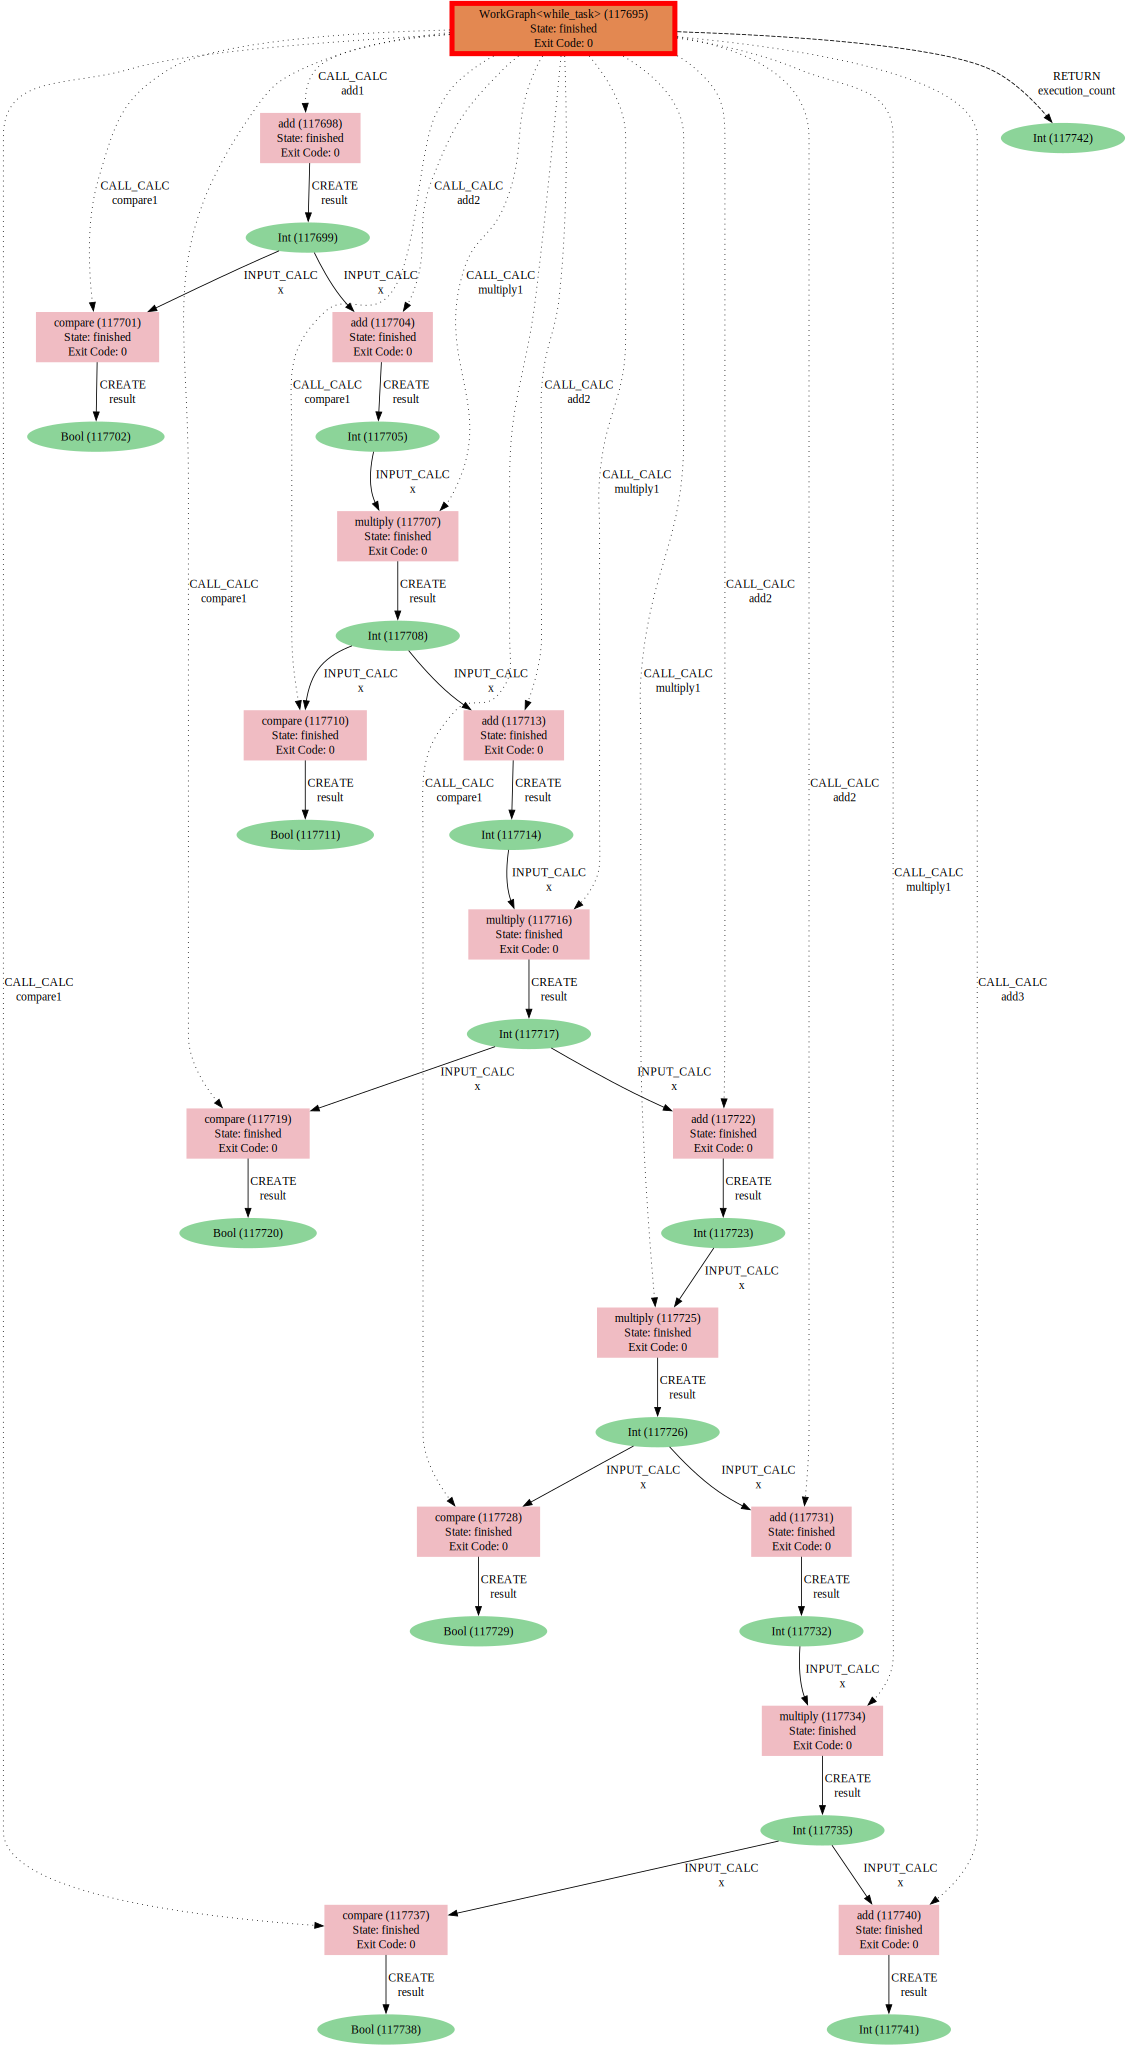

In [13]:
from aiida_workgraph.utils import generate_node_graph
generate_node_graph(wg.pk)

## Using the While WorkGraph

One can use the `graph_builder` decorator to dynamically create a WorkGraph that repeats based on defined conditions. This method is suitable for complex scenarios.

In [14]:
# Output the result of from the context (context)
@task.graph_builder(outputs = [{"name": "result", "from": "context.n"}])
def add_multiply_while(n, limit=50):
    wg = WorkGraph()
    # tell the engine that this is a `while` workgraph
    wg.workgraph_type = "WHILE"
    # the `result` of compare1 taskis used as condition
    wg.conditions = ["compare1.result"]
    # set a context variable before running.
    wg.context = {"n": n}
    wg.add_task(compare, name="compare1", x="{{n}}", y=limit)
    add1 = wg.add_task(add, name="add1", x="{{ n }}", y=1)
    multiply1 = wg.add_task(multiply, name="multiply1", x=add1.outputs["result"],
                            y=2)
    # update the context variable
    multiply1.set_context({"n": "result"})
    return wg

### Create the workflow
Now, let'use the `add_multiply_while` task in the workflow.

In [15]:
wg = WorkGraph("while_graph_builder")
add1 = wg.add_task(add, name="add1", x=1, y=1)
while1 = wg.add_task(add_multiply_while, name="add_multiply_while1",
                     n=add1.outputs["result"],
                     limit=50)
add2 = wg.add_task(add, name="add2", y=1)
wg.add_link(while1.outputs["result"], add2.inputs["x"])
wg.to_html()
# wg

In the GUI, we only see the `add_multiply_while1` task. When this task run, it will generate a `WorkGraph` based on the input value. This is different from the `While` task, in which we see all tasks before the WorkGraph run.


### Submit the WorkGraph and check the results

In [16]:
wg.submit(wait=True)
print("State of WorkGraph:   {}".format(wg.state))
print('Result of add2  :   {}'.format(wg.tasks["add2"].outputs["result"].value))

/home/xing/miniconda3/envs/aiida/lib/python3.11/site-packages/aiida/storage/psql_dos/orm/nodes.py:224: SAWarning: Object of type <DbNode> not in session, add operation along 'DbUser.dbnodes' will not proceed
  session.commit()


WorkGraph process created, PK: 117743
State of WorkGraph:   FINISHED
Result of add2  :   uuid: 4ba92c1b-9bb0-4e1e-9878-1e6d3d152d57 (pk: 117793) value: 63


Generate node graph from the AiiDA process,and we can see that when `compare1` node outputs `False`, the workgraph stops.

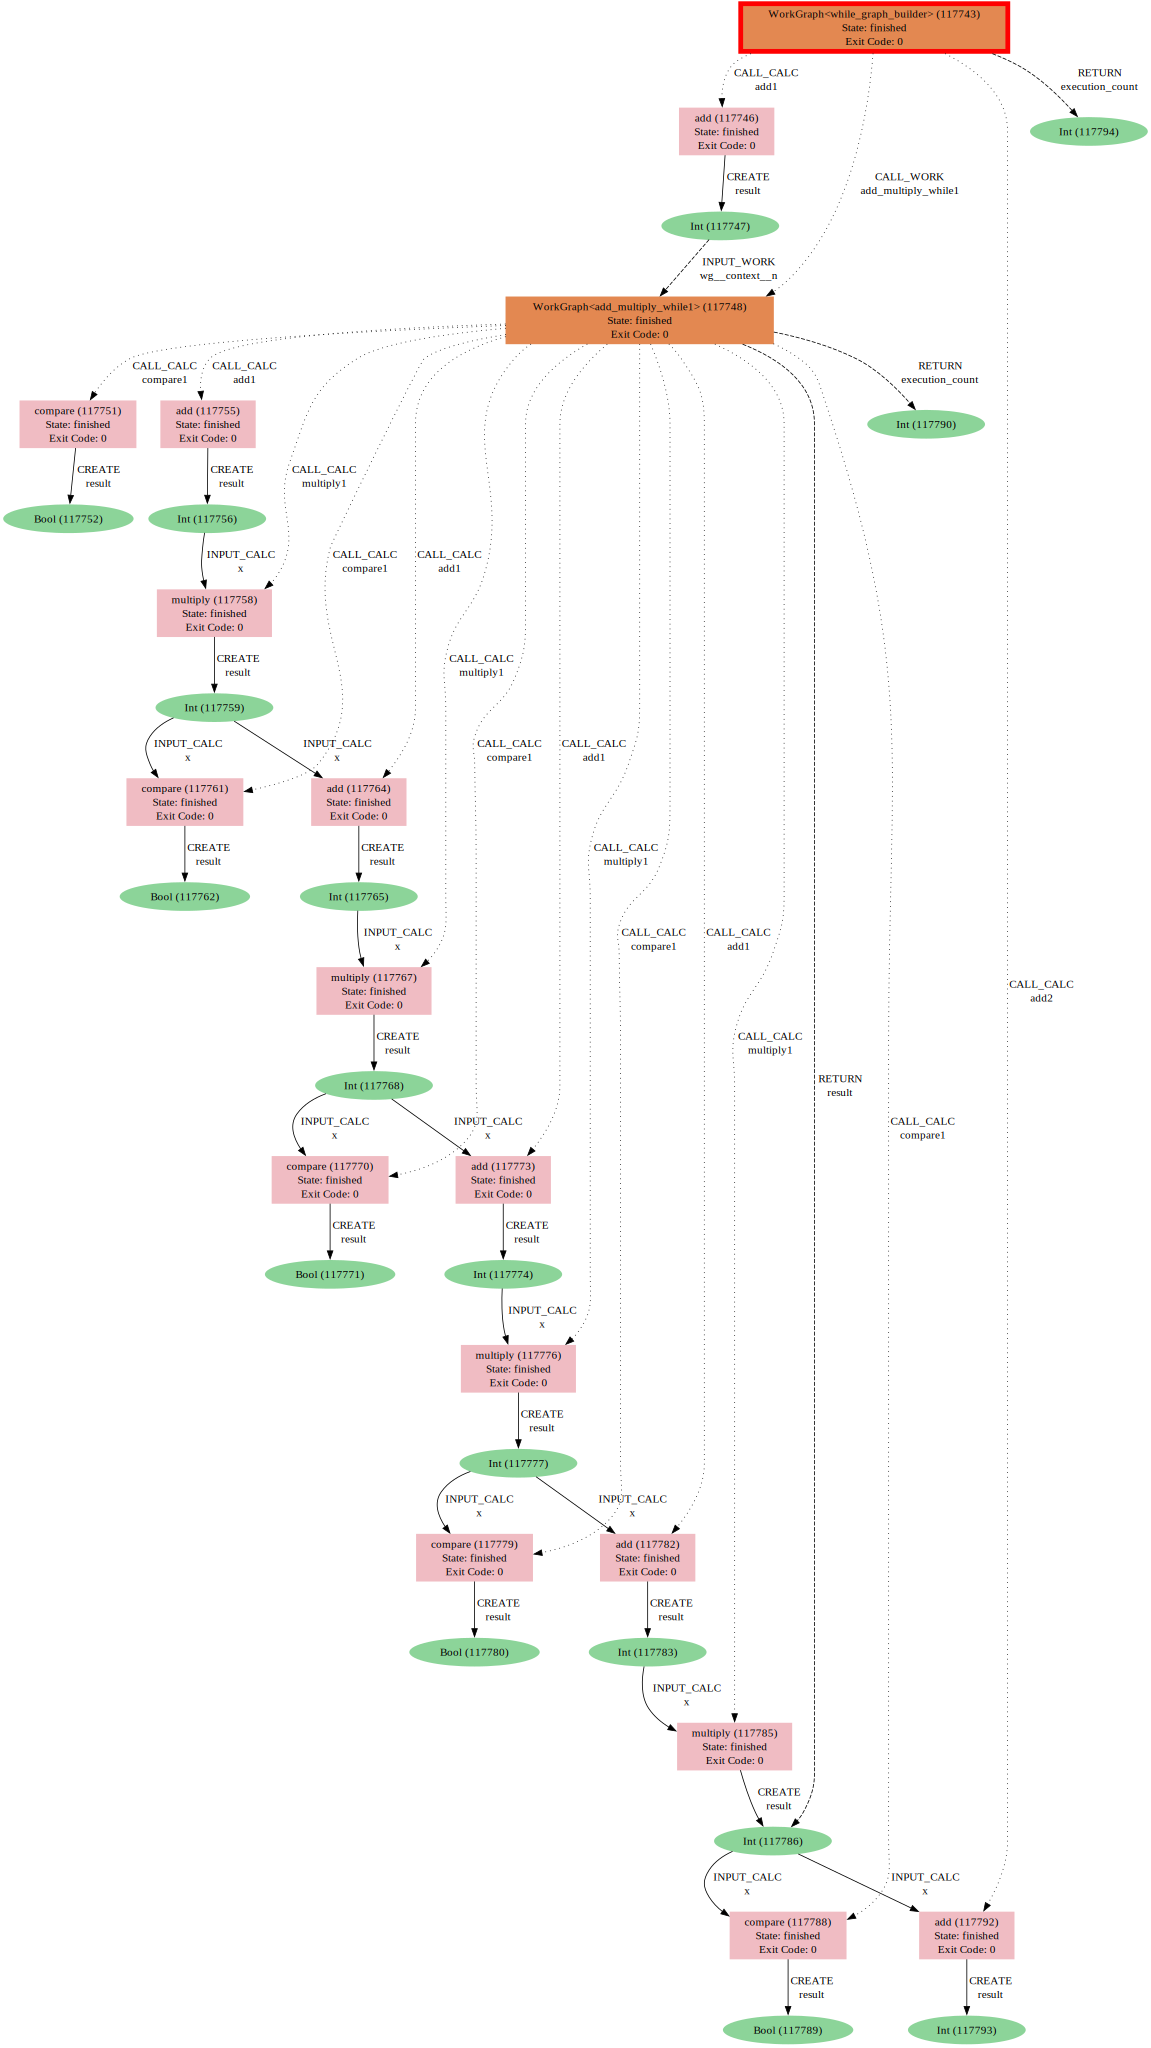

In [17]:
from aiida_workgraph.utils import generate_node_graph
generate_node_graph(wg.pk)

### Max iteration
One can set the maximum number of execution times (`max_iteration`) for the `While` WorkGraph.

In [ ]:
wg = WorkGraph()
wg.workgraph_type = "WHILE"
wg.max_iterations = 10


## Using the While Task
Internally, the `while_` instruction is used to implement the `While` task. The `While` task in WorkGraph is designed to run a set of tasks multiple times within a loop. You can add a `While` task to your WorkGraph and configure it with specific conditions and tasks to be executed repeatedly.

- **max_iterations**: Specifies the maximum number of iterations the loop should execute to prevent infinite loops.
- **conditions**: The loop will terminate when any condition evaluates to `False`. This input can be the outputs of other tasks, or a list of boolean expressions derived from the `context` variables. 

Here's a simple example to add a `While` task to a WorkGraph:
```python
while_task = wg.add_task("While", name="while_loop",
            max_iterations=100)
```

### Adding tasks to the While loop
We can add tasks to the `While` zone using the `add_task` method.

```python
# Add a new task to the while zone
while_zone1.add_task(add, name="task1", a=1, b=2)
```


In [ ]:
from aiida_workgraph import task, WorkGraph

wg = WorkGraph("while_task")
# set a context variable before running.
wg.context = {"should_run": True}
add1 = wg.add_task(add, name="add1", x=1, y=1)
add1.set_context({"n": "result"})
#---------------------------------------------------------------------
# Create the while zone
compare1 = wg.add_task(compare, name="compare1", x="{{n}}", y=50)
while_zone1 = wg.add_task("While", max_iterations=100, conditions=compare1.outputs["result"])
while_zone1.waiting_on.add("add1")
# Create the tasks in the while zone.
add2 = while_zone1.add_task(add, name="add2", x="{{n}}", y=1)
multiply1 = while_zone1.add_task(multiply, name="multiply1",
                        x=add2.outputs["result"],
                        y=2)
# update the context variable
multiply1.set_context({"n": "result"})
#---------------------------------------------------------------------
add3 = wg.add_task(add, name="add3", x=1, y=1)
wg.add_link(multiply1.outputs["result"], add3.inputs["x"])
wg.to_html()
# comment out the following line to visualize the graph in the notebook
# wg

### Summary

This tutorial introduces two approaches to implement `while` loops in WorkGraph: the straightforward `while_` instruction for standard looping scenarios, and the more dynamic `While WorkGraph` for complex workflows.
